# Problem 4. Random Forest Classifier

# Imports

In [1]:
from scipy import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Dataset (Same as Problem-1)

In [2]:
mat_file = io.loadmat('face.mat')

face_datas = mat_file['X']
face_labels = mat_file['l']
face_labels = face_labels.flatten()

print(face_datas.shape) #520개의 image
print(face_labels.shape) #520개의 label
print("Number of face labels: {}".format(len(np.unique(face_labels))))

#train-test split : 8 / 2 images for each ID
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
train_index, test_index = next(sss.split(face_datas.T, face_labels.T))

X_train, X_test = face_datas.T[train_index], face_datas.T[test_index]
y_train, y_test = face_labels.T[train_index], face_labels.T[test_index]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2576, 520)
(520,)
Number of face labels: 52
(416, 2576) (104, 2576) (416,) (104,)


# PCA (from Problem 1.) (Fast)

In [3]:
from sklearn.preprocessing import normalize

n_eigvecs = 150     #10,52(class_num),100,200,300

#Compute eigenvectors and eigenvalues (low-dimensional approach)
mean_train = np.mean(X_train, axis=0)
A_train = X_train - mean_train
N_train = X_train.shape[0]
M_low =(A_train@A_train.T) * (1/N_train)
eigvals_low, eigvecs_low = np.linalg.eig(M_low)

#sorting in top-down order
idx_low = eigvals_low.argsort()[::-1]   
eigvals_low = eigvals_low[idx_low]
eigvecs_low = eigvecs_low[:,idx_low]
eigvecs_low = A_train.T@eigvecs_low
#print(eigvecs_low.shape)
eigvecs_low = normalize(eigvecs_low,axis=0)

coeff = eigvecs_low[:,:n_eigvecs]

print("num of selected eigenfaces: {}".format(n_eigvecs))

#Transform test & train sets
X_train_pca = X_train @ coeff
X_test_pca = X_test @ coeff
print(X_train_pca.shape, X_test_pca.shape)

num of selected eigenfaces: 150
(416, 150) (104, 150)


# Functions

In [4]:
def face_visualizer(vector, facenum, test_set, correct=True):
    f, axes = plt.subplots(1, int(facenum), figsize=(8,3))
    f.suptitle("{n} {c} Predictions".format(n=facenum, c="Correct" if correct else "Incorrect"),fontsize=16)
    for i in range (facenum):
        tempvec = np.real(vector[i,:])
        axes = axes.flatten()
        a = axes[i]
        a.set_title("face {}".format(i+1))
        a.axis('off')
        a.imshow(np.reshape(tempvec,(46,56)).T, cmap = 'gist_gray')
    f.savefig("p4_images/rf_examples_{}.png".format("correct" if correct else "incorrect"),dpi=300)
    plt.show()

In [5]:
def test_rf_model(model_params, rf, X_train, y_train, X_test, y_test, X_test_original) :
    #Model Parameters
    #print("Model Parameters :")

    #Results
    results = {}

    #Training
    #print("Fitting the classifier to the training set..")
    t0 = time.time()
    #rf = RandomForestClassifier(oob_score=True)
    rf.fit(X_train, y_train)
    t1 = (time.time() - t0)
    results['train_time'] = t1

    #Testing
    predicted = rf.predict(X_test)
    results['predictions'] = predicted

    #2. Accuracy
    accuracy = accuracy_score(y_test, predicted)
    print(f'Mean accuracy score: {accuracy:.3} / ',end='')
    results['accuracy'] = accuracy

    #3. Confusion Matrix -> png
    cm = confusion_matrix(y_test, predicted)
    results['confmat'] = cm

    #4. Train/Test times
    print("Training done in %0.3fs" % t1)

    return results

# Testing the model

In [6]:
#Model Parameters
from math import e
fr = 1-1/e   #f ~= 63.2(%)

model_params = {
    "n_trees" : [1,10,50,100,500,1000],                     #500            #Number of trees
    "max_depth" : [1,2,5,10,15,20],                         #10             #Depth of trees
    "bootstrap" : True,                                     #True           #Use bootstrap - subsets to build each tree
    "max_samples_frac" : [0.1,0.2,0.5,fr,1.0],              #(1-1/e)          #Size of each bootstrap-subset : randomness
    "max_features_frac" : [1e-3,0.01,0.05,0.1,0.2,0.5,1.0], #0.1         #Use subset of features for node optimization (splitting) : randomness
    "criterion" : "entropy",                                #Objective function for split : "gini"(default),"log_loss","entropy"
    "random_state" : 0,
}

1. Number of trees

In [7]:
results_1 = {}
acc_list = []
time_list = []

for i in model_params['n_trees']:
    print("Number of trees : {}".format(i))
    rf = RandomForestClassifier(n_estimators=i,
                                max_depth=10,
                                bootstrap=model_params['bootstrap'],
                                max_samples=fr,
                                max_features=0.1,
                                criterion=model_params['criterion'],
                                random_state=model_params['random_state']
                                )
    result = test_rf_model(model_params, rf, X_train_pca, y_train, X_test_pca, y_test, X_test)
    acc_list.append(result['accuracy'])
    time_list.append(result['train_time'])
results_1['x'] = model_params['n_trees']
results_1['acc'] = acc_list
results_1['time'] = time_list

# fig, a = plt.subplots()
# twin = a.twinx()
# l1, = a.plot(results_1['x'],results_1['acc'],'b-', label='Accuracy')
# l2, = twin.plot(results_1['x'],results_1['time'],'r-', label='Train time (s)')
# a.set_ylim(0,1)
# a.set_xlabel('T : Number of trees')
# a.set_ylabel('Accuracy')
# twin.set_ylabel('Train time (s)')
# a.legend(handles=[l1,l2],loc='upper left')
# fig.savefig('p4_results/1_acc_time_Ntrees.png',dpi=300)

Number of trees : 1
Mean accuracy score: 0.106 / Training done in 0.018s
Number of trees : 10
Mean accuracy score: 0.154 / Training done in 0.168s
Number of trees : 50
Mean accuracy score: 0.471 / Training done in 0.651s
Number of trees : 100
Mean accuracy score: 0.615 / Training done in 1.085s
Number of trees : 500
Mean accuracy score: 0.779 / Training done in 5.198s
Number of trees : 1000
Mean accuracy score: 0.788 / Training done in 10.412s


2. Max tree-depth

In [8]:
results_2 = {}
acc_list = []
time_list = []

for i in model_params['max_depth']:
    print("Max tree-depth : {}".format(i))
    rf = RandomForestClassifier(n_estimators=500,
                                max_depth=i,
                                bootstrap=model_params['bootstrap'],
                                max_samples=fr,
                                max_features=0.1,
                                criterion=model_params['criterion'],
                                random_state=model_params['random_state']
                                )
    result = test_rf_model(model_params, rf, X_train_pca, y_train, X_test_pca, y_test, X_test)
    acc_list.append(result['accuracy'])
    time_list.append(result['train_time'])
results_2['x'] = model_params['max_depth']
results_2['acc'] = acc_list
results_2['time'] = time_list

# fig, a = plt.subplots()
# twin = a.twinx()
# l1, = a.plot(results_2['x'],results_2['acc'],'b-', label='Accuracy')
# l2, = twin.plot(results_2['x'],results_2['time'],'r-', label='Train time (s)')
# a.set_ylim(0,1)
# a.set_xticks(np.arange(0,22,2))
# a.set_xlabel('M : Max tree-depth')
# a.set_ylabel('Accuracy')
# twin.set_ylabel('Train time (s)')
# a.legend(handles=[l1,l2],loc='upper left')
# fig.savefig('p4_results/2_acc_time_Depth.png',dpi=300)

Max tree-depth : 1
Mean accuracy score: 0.5 / Training done in 1.778s
Max tree-depth : 2
Mean accuracy score: 0.625 / Training done in 2.877s
Max tree-depth : 5
Mean accuracy score: 0.731 / Training done in 4.612s
Max tree-depth : 10
Mean accuracy score: 0.779 / Training done in 6.068s
Max tree-depth : 15
Mean accuracy score: 0.788 / Training done in 5.861s
Max tree-depth : 20
Mean accuracy score: 0.788 / Training done in 5.842s


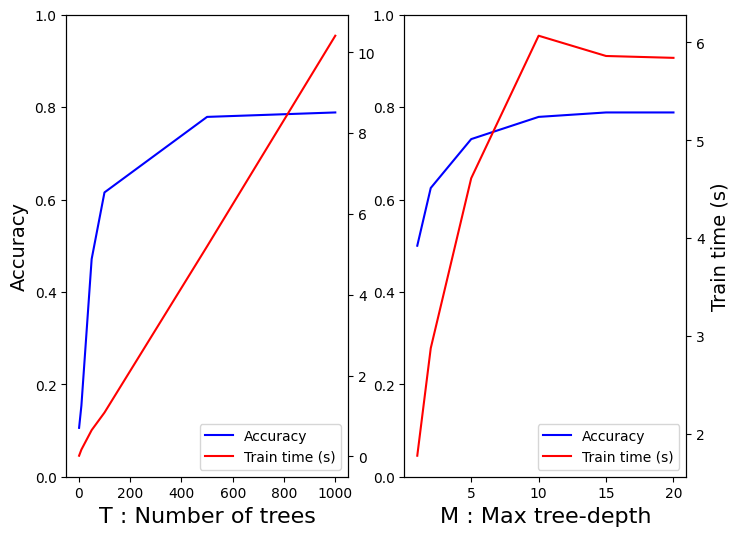

In [9]:
#Graph 1 & 2.
fig, axes = plt.subplots(1,2,figsize=(8,6))

a = axes[0]
twin = a.twinx()
l1, = a.plot(results_1['x'],results_1['acc'],'b-', label='Accuracy')
l2, = twin.plot(results_1['x'],results_1['time'],'r-', label='Train time (s)')
a.set_ylim(0,1)
a.set_xlabel('T : Number of trees',fontsize=16)
a.set_ylabel('Accuracy',fontsize=14)
a.legend(handles=[l1,l2],loc='lower right')

a = axes[1]
twin = a.twinx()
l1, = a.plot(results_2['x'],results_2['acc'],'b-', label='Accuracy')
l2, = twin.plot(results_2['x'],results_2['time'],'r-', label='Train time (s)')
a.set_ylim(0,1)
#a.set_xticks(np.arange(0,22,2))
a.set_xlabel('M : Max tree-depth',fontsize=16)
twin.set_ylabel('Train time (s)',fontsize=14)
a.legend(handles=[l1,l2],loc='lower right')

fig.savefig('p4_results/6_Ntrees_Depth.png',dpi=300)

3. Randomness Parameter : Bootstrap sample size

In [10]:
results_3 = {}
acc_list = []
time_list = []

for i in model_params['max_samples_frac']:
    print("Subsample rate : {}".format(i))
    rf = RandomForestClassifier(n_estimators=500,
                                max_depth=10,
                                bootstrap=model_params['bootstrap'],
                                max_samples=i,
                                max_features=0.1,
                                criterion=model_params['criterion'],
                                random_state=model_params['random_state']
                                )
    result = test_rf_model(model_params, rf, X_train_pca, y_train, X_test_pca, y_test, X_test)
    acc_list.append(result['accuracy'])
    time_list.append(result['train_time'])
results_3['x'] = model_params['max_samples_frac']
results_3['acc'] = acc_list
results_3['time'] = time_list

# fig, a = plt.subplots()
# twin = a.twinx()
# l1, = a.plot(results_3['x'],results_3['acc'],'b-', label='Accuracy')
# l2, = twin.plot(results_3['x'],results_3['time'],'r-', label='Train time (s)')
# a.set_ylim(0,1)
# a.set_xlabel('B : Bagging-subset size')
# a.set_ylabel('Accuracy')
# twin.set_ylabel('Train time (s)')
# a.legend(handles=[l1,l2],loc='upper left')
# fig.savefig('p4_results/3_acc_time_R_bootstrap.png',dpi=300)

Subsample rate : 0.1
Mean accuracy score: 0.442 / Training done in 0.892s
Subsample rate : 0.2
Mean accuracy score: 0.683 / Training done in 1.722s
Subsample rate : 0.5
Mean accuracy score: 0.75 / Training done in 4.550s
Subsample rate : 0.6321205588285577
Mean accuracy score: 0.779 / Training done in 5.869s
Subsample rate : 1.0
Mean accuracy score: 0.788 / Training done in 8.369s


4. Randomness Parameter : Feature Selection rate

In [11]:
results_4 = {}
acc_list = []
time_list = []

for i in model_params['max_features_frac']:
    print("Feature selection rate : {}".format(i))
    rf = RandomForestClassifier(n_estimators=500,
                                max_depth=10,
                                bootstrap=model_params['bootstrap'],
                                max_samples=fr,
                                max_features=i,
                                criterion=model_params['criterion'],
                                random_state=model_params['random_state']
                                )
    result = test_rf_model(model_params, rf, X_train_pca, y_train, X_test_pca, y_test, X_test)
    acc_list.append(result['accuracy'])
    time_list.append(result['train_time'])
results_4['x'] = model_params['max_features_frac']
results_4['acc'] = acc_list
results_4['time'] = time_list

# fig, a = plt.subplots()
# twin = a.twinx()
# l1, = a.plot(results_4['x'],results_4['acc'],'b-', label='Accuracy')
# l2, = twin.plot(results_4['x'],results_4['time'],'r-', label='Train time (s)')
# a.set_ylim(0,1)
# a.set_xlabel('F : Feature subsample size')
# a.set_ylabel('Accuracy')
# twin.set_ylabel('Train time (s)')
# a.legend(handles=[l1,l2],loc='upper left')
# fig.savefig('p4_results/4_acc_time_R_featureset.png',dpi=300)

Feature selection rate : 0.001
Mean accuracy score: 0.587 / Training done in 0.874s
Feature selection rate : 0.01
Mean accuracy score: 0.587 / Training done in 0.881s
Feature selection rate : 0.05
Mean accuracy score: 0.74 / Training done in 3.025s
Feature selection rate : 0.1
Mean accuracy score: 0.779 / Training done in 5.839s
Feature selection rate : 0.2
Mean accuracy score: 0.731 / Training done in 10.499s
Feature selection rate : 0.5
Mean accuracy score: 0.692 / Training done in 24.746s
Feature selection rate : 1.0
Mean accuracy score: 0.635 / Training done in 45.205s


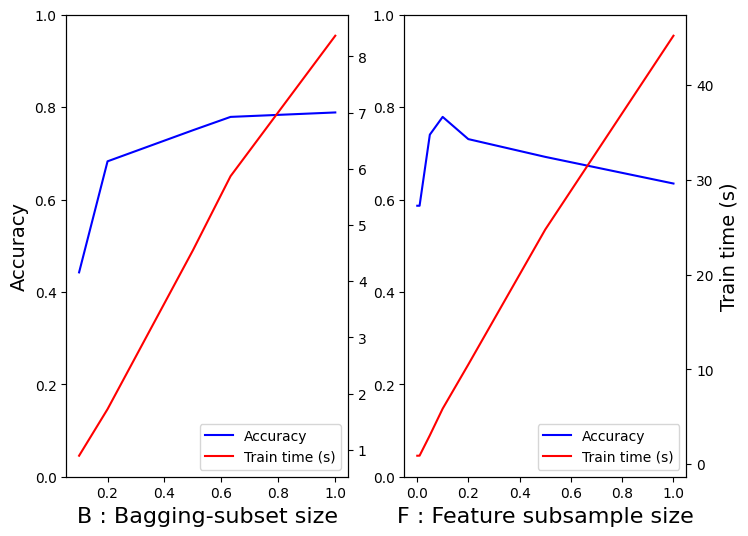

In [12]:
#Graph 3 & 4.
fig, axes = plt.subplots(1,2,figsize=(8,6))

a = axes[0]
twin = a.twinx()
l1, = a.plot(results_3['x'],results_3['acc'],'b-', label='Accuracy')
l2, = twin.plot(results_3['x'],results_3['time'],'r-', label='Train time (s)')
a.set_ylim(0,1)
#a.set_xticks(np.arange(0,22,2))
a.set_xlabel('B : Bagging-subset size',fontsize=16)
a.set_ylabel('Accuracy',fontsize=14)
#twin.set_ylabel('Train time (s)')
a.legend(handles=[l1,l2],loc='lower right')

a = axes[1]
twin = a.twinx()
l1, = a.plot(results_4['x'],results_4['acc'],'b-', label='Accuracy')
l2, = twin.plot(results_4['x'],results_4['time'],'r-', label='Train time (s)')
a.set_ylim(0,1)
#a.set_xticks(np.arange(0,22,2))
a.set_xlabel('F : Feature subsample size',fontsize=16)
#a.set_ylabel('Accuracy')
twin.set_ylabel('Train time (s)',fontsize=14)
a.legend(handles=[l1,l2],loc='lower right')

fig.savefig('p4_results/7_Bootstrap_Featureset.png',dpi=300)

# Best Model
- E / N_eigvecs = 150
- T / N_trees = 1000
- M / Max_depth = 15
- B / Bagging = 1-1/e ~= 0.632
- F / Randomised node optimization = 0.1

In [13]:
rf_best = RandomForestClassifier(n_estimators=1000,
                                max_depth=15,
                                bootstrap=model_params['bootstrap'],
                                max_samples=fr,
                                max_features=0.1,
                                criterion=model_params['criterion'],
                                random_state=model_params['random_state']
                                )
result = test_rf_model(model_params, rf_best, X_train_pca, y_train, X_test_pca, y_test, X_test)

# Confusion matrix
# cmp = ConfusionMatrixDisplay(result['confmat'])
# fig, ax = plt.subplots(figsize=(15,12))
# cmp.plot(ax=ax)
# fig.savefig("p4_results/5_rf_best_confusion_matrix.png",dpi=300)

Mean accuracy score: 0.808 / Training done in 10.278s


In [14]:
out = {}
out['cm'] = result['confmat']
out['pred'] = result['predictions']
io.savemat('RF_best.mat',out)

# P2 results - graph

In [15]:
# p2_results = io.loadmat('p2_acc_n_eigvecs.mat')['results']
# X = p2_results['n_eigvecs'][0][0][0]
# Y = p2_results['acc'][0][0][0]
# print(Y)

# fig, a = plt.subplots()
# a.plot(X,Y,'b-', label='PCA(fast)')

# a.set_xlabel('E : #. of Eigenfaces')
# a.set_ylabel('NN-Classification Accuracy')

# a.legend(loc='lower right')
# fig.savefig('p4_results/0_pca_acc_n_eigvecs.png',dpi=200)